# Load and work with ang files for nice plots
### Takes .ang files, loads them, visualises as phase and IPF plots, generates plottable figures and more

### Need to install orix

In [1]:
#file finding and loading
import os, fnmatch


#orix imports
from orix import data, io, plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, symmetry
from orix.vector import Vector3d, Miller, AxAngle
from orix.crystal_map import Phase
from orix.quaternion import Orientation, OrientationRegion, Rotation, Misorientation
from orix.quaternion.symmetry import C1, Oh

#standard imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np 
import pandas as pd

# Import scikit-learn DBSCAN
from sklearn.cluster import DBSCAN

# Colorisation & Animation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb

In [2]:
#set up the Laue groups for plotting the IPF keys
pg_laue = [
    symmetry.Ci,
    symmetry.C2h,
    symmetry.D2h,
    symmetry.S6,
    symmetry.D3d,
    symmetry.C4h,
    symmetry.D4h,
    symmetry.C6h,
    symmetry.D6h,
    symmetry.Th,
    symmetry.Oh,
]
pg_HCP = pg_laue[8]
pg_BCC = pg_laue[10]

## Load and check data

In [3]:
### Load ang file, minor text fixing to ang files (correcting point group symmetry) 
# may be necessary to make them load correctly
filepath = '/local/scratch/EnriqueTitanium/2019_10_04_Ti_550/Scan5/'


In [4]:
paths = os.listdir(filepath)
files = []
for file in paths:
    if fnmatch.fnmatch(file, '*alphabeta.ang'):
        files = files+[file]
files.sort()
print('Here is your file list:')
files

Here is your file list:


['Ti550_scan5_13_10_norot2_alphabeta.ang',
 'Ti550_scan5_13_10_norot_alphabeta.ang',
 'Ti550_scan5_13_10_swap_alphabeta.ang',
 'Ti550_scan5_rot_13_10_alphabeta.ang',
 'Ti550_scan5_rot_13_10_rot90_alphabeta.ang',
 'Ti550_scan5_rot_alphabeta.ang']

In [5]:
file = files[0]
Timap = io.load(filepath+file)

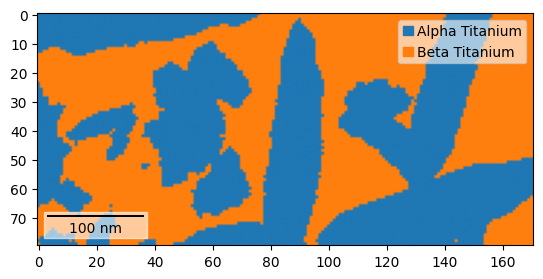

In [6]:
# Rough plot, only shows phases
Timap = Timap[:-20,20:]
Timap.plot()

In [7]:
# find width and height from ang file
width = int(Timap.x.max()/(Timap.x[1]-Timap.x[0]))
height = int(Timap.y.max()/(Timap.x[1]-Timap.x[0]))
print('Height =', height, 'pixels. Width =', width, 'pixels')

Height = 79 pixels. Width = 190 pixels


In [8]:
# Lists out the phase data
Timap.phases

Id            Name  Space group  Point group  Proper point group       Color
 1  Alpha Titanium         None          622                 622    tab:blue
 2   Beta Titanium         None          432                 432  tab:orange

In [9]:
Timap

Phase   Orientations            Name  Space group  Point group  Proper point group       Color
    1   6984 (51.1%)  Alpha Titanium         None          622                 622    tab:blue
    2   6696 (48.9%)   Beta Titanium         None          432                 432  tab:orange
Properties: iq, ci, detector_signal, fit
Scan unit: nm

In [10]:
# Add correct space group information as not in .ang file
Timap.phases[1].space_group = 194
Timap.phases[2].space_group = 229

In [11]:
# Just print various bits of info to check
print(Timap.phases.names)
print([i.short_name for i in Timap.phases.space_groups])
print([i.name for i in Timap.phases.point_groups])
print([i.proper_subgroup.name for i in Timap.phases.point_groups])
print(Timap.phases.colors)
print(Timap.phases.structures)

['Alpha Titanium', 'Beta Titanium']
['P63/mmc', 'Im-3m']
['6/mmm', 'm-3m']
['622', '432']
['tab:blue', 'tab:orange']
[[], []]


In [12]:
# Check for the Alpha
Timap.phases["Alpha Titanium"]
print(Timap.phases["Alpha Titanium"].name)
print(Timap.phases["Alpha Titanium"].space_group.short_name)
print(Timap.phases["Alpha Titanium"].point_group.name)
print(Timap.phases["Alpha Titanium"].point_group.proper_subgroup.name)
print(Timap.phases["Alpha Titanium"].color)
print(Timap.phases["Alpha Titanium"].structure)

Alpha Titanium
P63/mmc
6/mmm
622
tab:blue
lattice=Lattice(base=array([[ 2.951     ,  0.        ,  0.        ],
       [-1.4755    ,  2.55564097,  0.        ],
       [ 0.        ,  0.        ,  4.681     ]]))



In [13]:
# Check for the Beta
Timap.phases["Beta Titanium"]
print(Timap.phases["Beta Titanium"].name)
print(Timap.phases["Beta Titanium"].space_group.short_name)
print(Timap.phases["Beta Titanium"].point_group.name)
print(Timap.phases["Beta Titanium"].point_group.proper_subgroup.name)
print(Timap.phases["Beta Titanium"].color)
print(Timap.phases["Beta Titanium"].structure)

Beta Titanium
Im-3m
m-3m
432
tab:orange
lattice=Lattice(a=3.232, b=3.232, c=3.232, alpha=90, beta=90, gamma=90)



## Plot IPFs

In [14]:
params = {
    'figure.figsize': (7, 7), 
    'font.size': 14,
    'axes.titlesize':20
}
plt.rcParams.update(params)

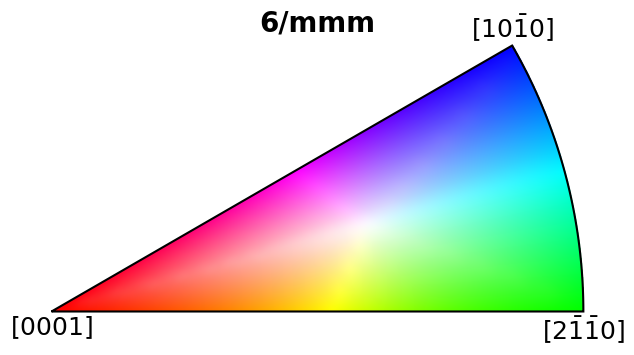

In [15]:
# Make the IPFkey and return a figure as a variable for use in next cell
plot.IPFColorKeyTSL(pg_HCP).plot()

(-0.2, 1.2)

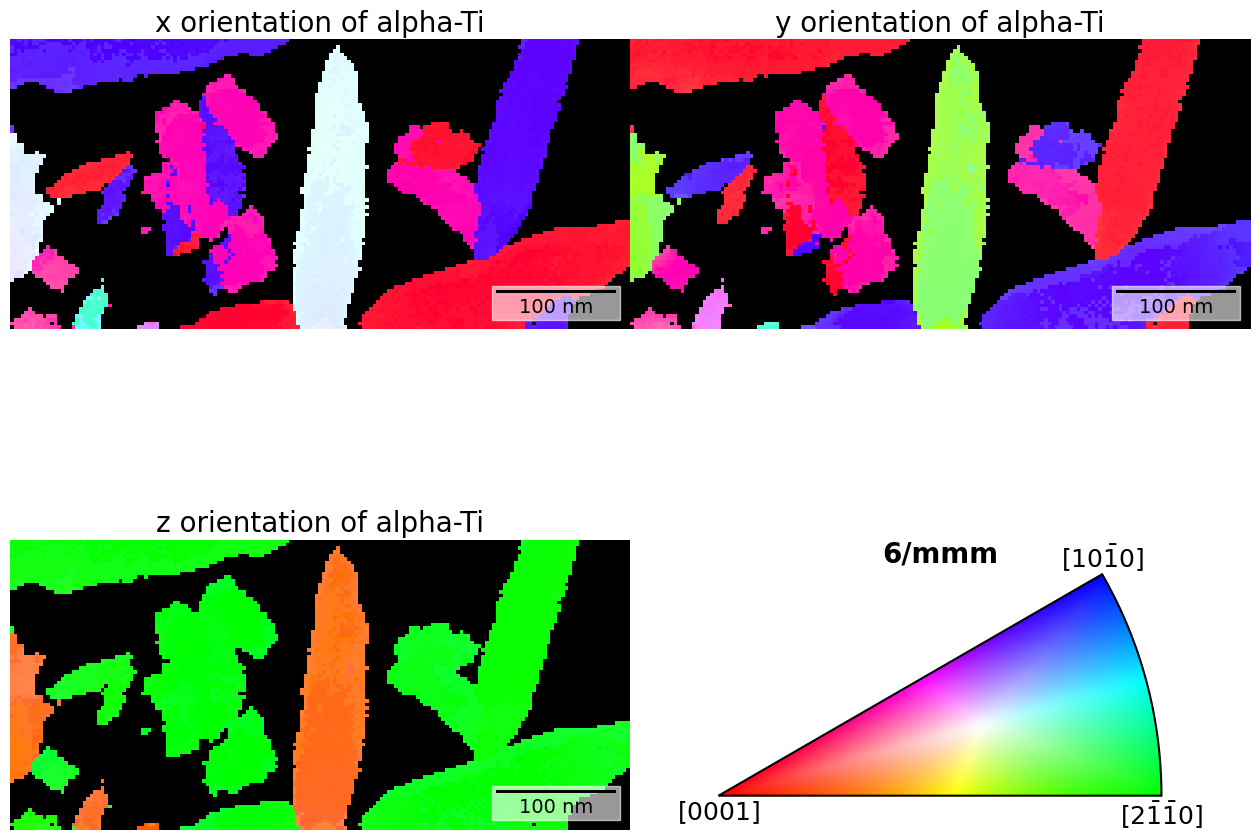

In [16]:
fig = plt.figure(figsize=(16,13))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0, hspace=0)

ckey_622_x = plot.IPFColorKeyTSL(pg_HCP, direction=Vector3d.yvector())
ckey_622_y = plot.IPFColorKeyTSL(pg_HCP, direction=Vector3d.xvector())
ckey_622_z = plot.IPFColorKeyTSL(pg_HCP, direction=Vector3d.zvector())
rgb_alpha_xyz = [ckey_622_x.orientation2color(Timap["Alpha Titanium"].orientations),
                 ckey_622_y.orientation2color(Timap["Alpha Titanium"].orientations),
                 ckey_622_z.orientation2color(Timap["Alpha Titanium"].orientations)
                ]
labels = ['x','y','z']
for n in range(3):
    i = n%2
    j = int(np.floor(n/2))
    ax = plt.subplot(gs[j,i], projection="plot_map")
    ax.plot_map(Timap["Alpha Titanium"], rgb_alpha_xyz[n], 
                 scalebar_properties={"location": 4})
    ax.set_title(labels[n]+' orientation of alpha-Ti', size = 20)
    ax.set_axis_off()
    
axb = plt.subplot(gs[1,1], projection='ipf', symmetry=pg_HCP)
axb.plot_ipf_color_key()
axb.set_xlim(-0.2,1.2)

#fig.savefig('ROI3_IPF_figure_alpha.png')

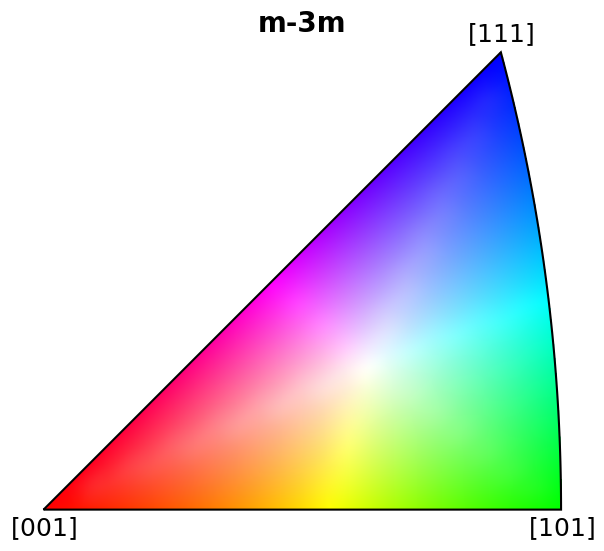

In [17]:
# Make the IPFkey and return a figure as a variable for use in next cell
plot.IPFColorKeyTSL(pg_BCC).plot()

(-0.1, 0.5)

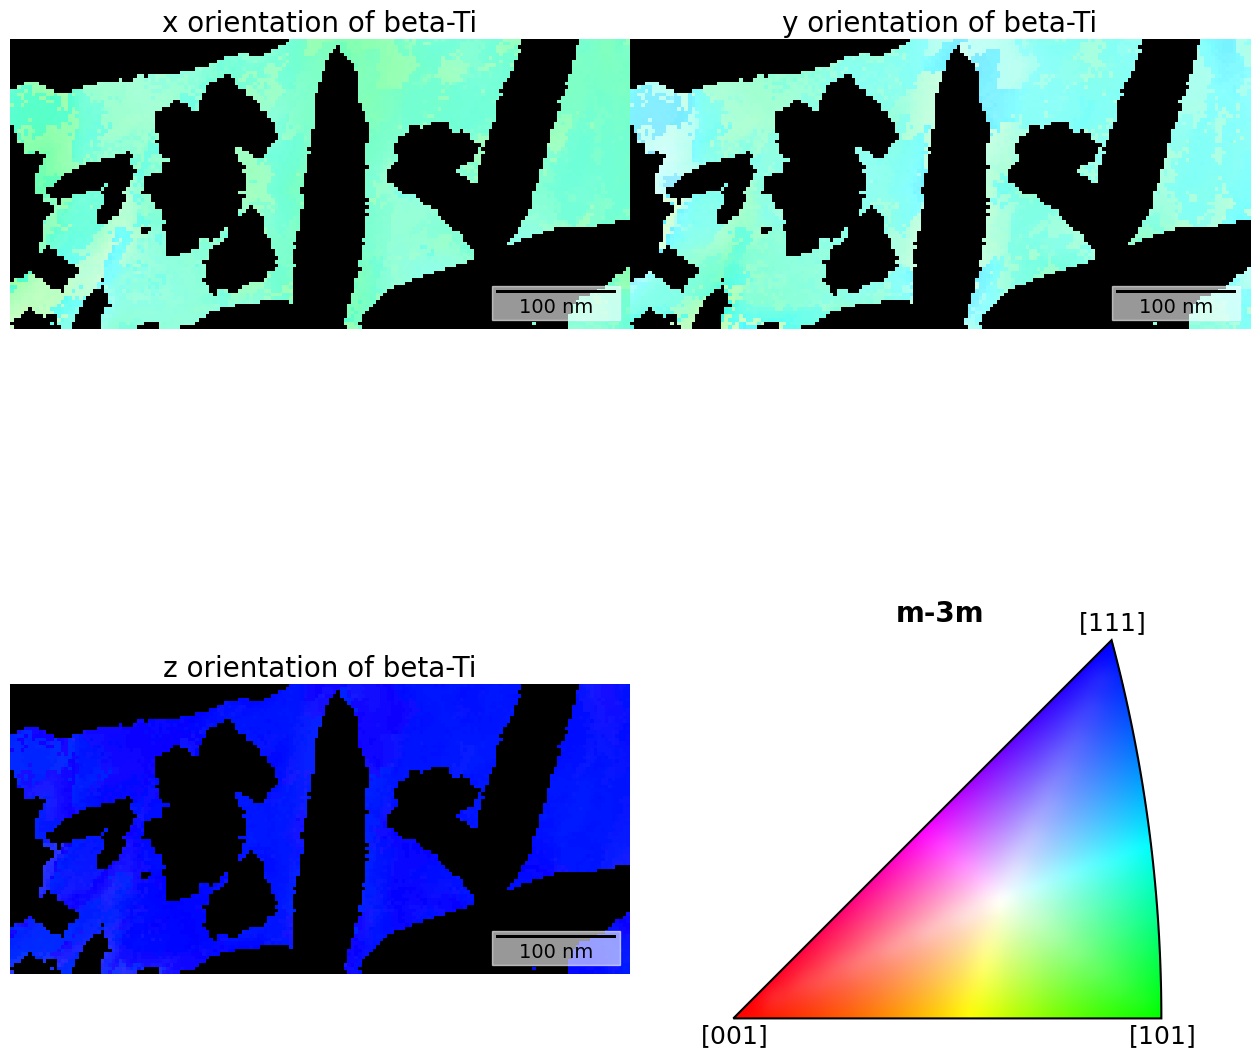

In [18]:
fig = plt.figure(figsize=(16,16.75))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0, hspace=0)

ckey_622_x_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.yvector())
ckey_622_y_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.xvector())
ckey_622_z_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.zvector())
rgb_beta_xyz = [ckey_622_x_BCC.orientation2color(Timap["Beta Titanium"].orientations),
                ckey_622_y_BCC.orientation2color(Timap["Beta Titanium"].orientations),
                ckey_622_z_BCC.orientation2color(Timap["Beta Titanium"].orientations)
               ]
labels = ['x','y','z']

for n in range(3):
    i = n%2
    j = int(np.floor(n/2))
    ax = plt.subplot(gs[j,i], projection="plot_map")
    ax.plot_map(Timap["Beta Titanium"], rgb_beta_xyz[n], 
                 scalebar_properties={"location": 4})
    ax.set_title(labels[n]+' orientation of beta-Ti', size = 20)
    ax.set_axis_off()
    
axb = plt.subplot(gs[1,1], projection='ipf', symmetry=pg_BCC)
axb.plot_ipf_color_key()
axb.set_xlim(-0.1,0.5)

#fig.savefig('ROI3_IPF_figure_beta.png')

## Plot of actual orientations back onto pole figures

In [19]:
plt.rcParams["axes.grid"] = True

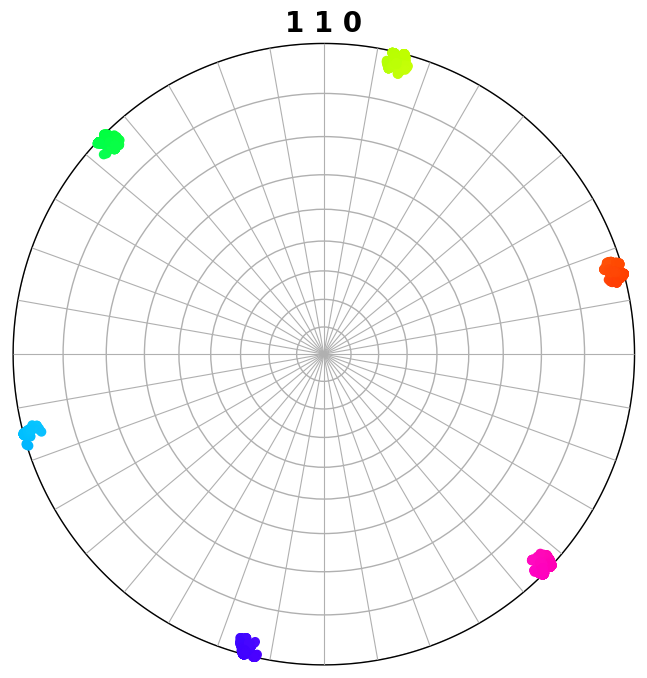

In [20]:
sym = symmetry.Ci
v = Vector3d((1, 1, 0))
ori_beta = ~Timap["Beta Titanium"].orientations
ipfkey = plot.IPFColorKeyTSL(sym, direction=v)
ori_beta.symmetry = ipfkey.symmetry
rgb_z = ipfkey.orientation2color(ori_beta)
ori_beta.scatter("ipf", c=rgb_z, direction=ipfkey.direction)


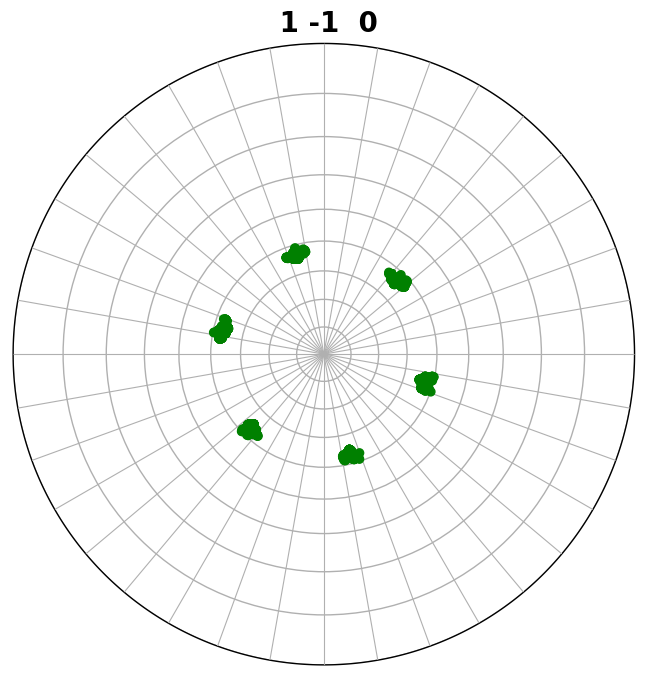

In [21]:
sym = symmetry.Ci
v = Vector3d((1, -1, 0))
ori_beta = ~Timap["Beta Titanium"].orientations
ipfkey = plot.IPFColorKeyTSL(sym, direction=v)
ori_beta.symmetry = ipfkey.symmetry
rgb_z = ipfkey.orientation2color(ori_beta)
ori_beta.scatter("ipf", c='g', direction=ipfkey.direction)


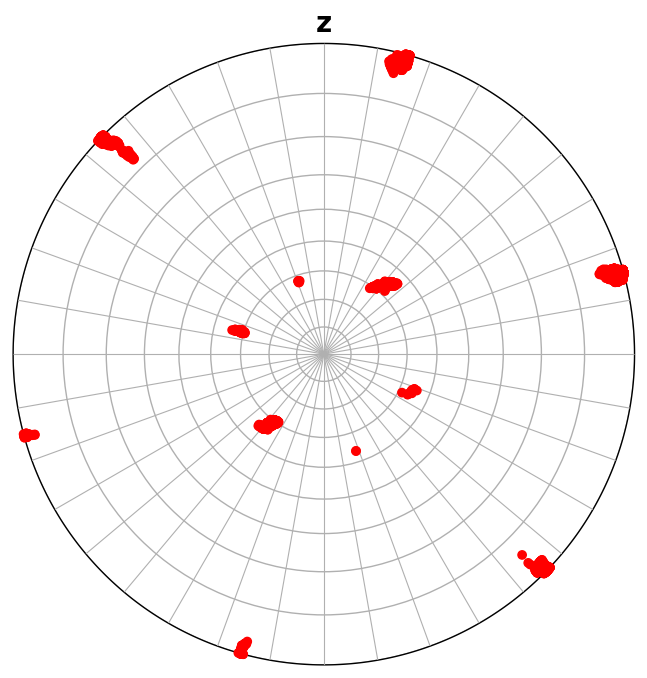

In [22]:
sym = symmetry.Ci
ori_alpha = ~Timap["Alpha Titanium"].orientations
ipfkey = plot.IPFColorKeyTSL(sym, direction=Vector3d.zvector())
ori_alpha.symmetry = ipfkey.symmetry
rgb_z = ipfkey.orientation2color(ori_alpha)
ori_alpha.scatter("ipf", c='r', direction=ipfkey.direction)

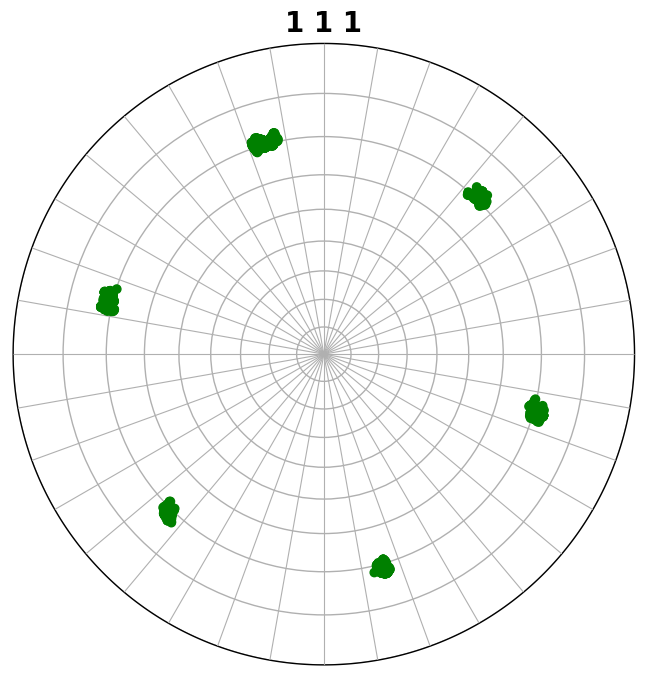

In [23]:
sym = symmetry.Ci
v = Vector3d((1, 1, 1))
ori_beta = ~Timap["Beta Titanium"].orientations
ipfkey = plot.IPFColorKeyTSL(sym, direction=v)
ori_beta.symmetry = ipfkey.symmetry
rgb_z = ipfkey.orientation2color(ori_beta)
ori_beta.scatter("ipf", c='g', direction=ipfkey.direction)


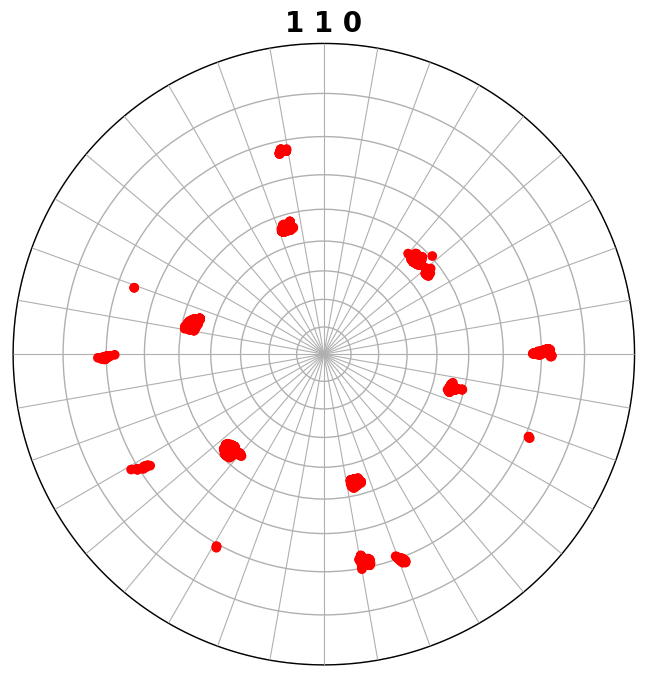

In [24]:
sym = symmetry.Ci
ori_alpha = ~Timap["Alpha Titanium"].orientations

ipfkey = plot.IPFColorKeyTSL(sym, direction=Vector3d((1,1,0)))
ori_alpha.symmetry = ipfkey.symmetry
rgb_z = ipfkey.orientation2color(ori_alpha)
ori_alpha.scatter("ipf", c='r', direction=ipfkey.direction)

## Decomposition of dataset

In [25]:
ori = Timap["Alpha Titanium"].orientations
ori = ~ori
ori.symmetry = pg_HCP

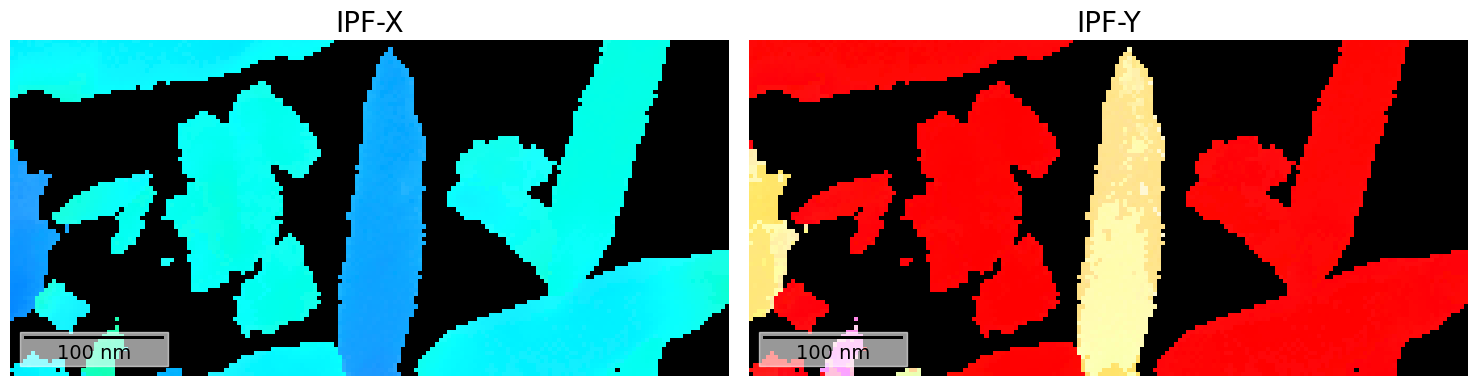

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10), subplot_kw=dict(projection="plot_map"))
directions = [(1, 0, 0), (0, 1, 0)]
titles = ["X", "Y"]
ckeys = [ckey_622_x, ckey_622_y]
for i in range(len(ax)):
    ax[i].plot_map(Timap["Alpha Titanium"], ckeys[i].orientation2color(ori))
    # Invert because orix assumes lab2crystal when coloring orientations
    ax[i].set_title(f"IPF-{titles[i]}")
    ax[i].axis("off")
fig.tight_layout()

In [27]:
ori2 = ori.map_into_symmetry_reduced_zone()

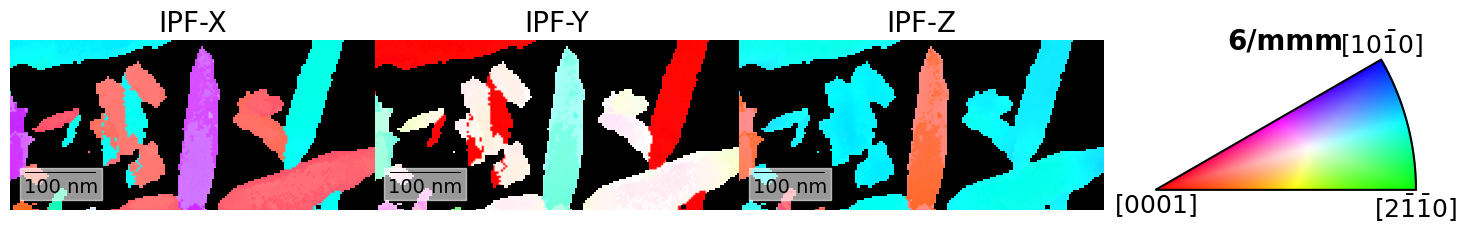

In [28]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1,4, figure=fig, wspace=0, hspace=0)
directions = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
titles = ["X", "Y", "Z"]
ckeys = [ckey_622_x, ckey_622_y, ckey_622_z]
for i in range(3):
    ax = plt.subplot(gs[0,i], projection="plot_map")
    ax.plot_map(Timap["Alpha Titanium"], 
                   ckeys[i].orientation2color(ori2))  
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")
axb = plt.subplot(gs[0,3], projection='ipf', symmetry=pg_HCP)
axb.set_xlim(-.2,1.2)
axb.plot_ipf_color_key()
fig.tight_layout()

In [29]:
# Increase the chunk size for a faster but more memory intensive computation
D = ori2.get_distance_matrix(lazy=True, chunk_size=1000)

[########################################] | 100% Completed | 7.06 sms


In [30]:
D = D.reshape(ori2.size, ori2.size)

In [31]:
# This call will use about 6 GB of memory, but the data precision of
# the D matrix can be reduced from float64 to float32 save memory:
D = D.astype(np.float32)

In [35]:
#Save the D file that takes a long time to calculate
np.save(filepath+'D_Scan5_13_10_norot', D)

In [28]:
D = np.load(filepath+'D_Scan5_13_10_norot.npy')

In [32]:
lim = np.radians(15)

In [33]:
#Sort into clusters
dbscan = DBSCAN(
                eps=lim,  # Max. distance between two samples in radians
                min_samples=40,
                metric="precomputed"
                ).fit(D)

unique_labels, all_cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print("Labels:", unique_labels)

all_labels = dbscan.labels_.reshape(ori.shape)
n_clusters = unique_labels.size - 1
print("Number of clusters:", n_clusters)

Labels: [-1  0  1  2  3  4  5  6  7]
Number of clusters: 8


In [34]:
# Work out quaternions for each unique orientation
unique_cluster_labels = unique_labels[1:]  # Without the "no-cluster" label -1
cluster_sizes = all_cluster_sizes[1:]

q_mean = [ori[all_labels == l].mean() for l in unique_cluster_labels]
cluster_means = Orientation.stack(q_mean).flatten()

# Map into the fundamental zone
cluster_means.symmetry = pg_HCP
cluster_means = cluster_means.map_into_symmetry_reduced_zone()
cluster_means

Orientation (8,) 6/mmm
[[ 0.7207  0.091  -0.6796  0.1023]
 [-0.9631 -0.2176  0.1329  0.0861]
 [ 0.9505 -0.2354  0.1873 -0.0778]
 [ 0.7137 -0.5517 -0.4191  0.103 ]
 [ 0.7118  0.5567  0.4149  0.1057]
 [-0.7109  0.6477 -0.2608 -0.0842]
 [-0.7052 -0.6516  0.2665 -0.0837]
 [-0.9485  0.0247  0.2676  0.1674]]

In [35]:
# Reference to one of the orientations
reference = 3

ori_recentered = (~cluster_means[reference]) * ori2

# Map into the fundamental zone
ori_recentered.symmetry = pg_HCP
ori_recentered = ori_recentered.map_into_symmetry_reduced_zone()

cluster_means_recentered = Orientation.stack(
    [ori_recentered[all_labels == l].mean() for l in unique_cluster_labels]
).flatten()
cluster_means_recentered

Orientation (8,) 1
[[ 0.8656  0.2197 -0.45   -0.0063]
 [ 0.719  -0.6937 -0.0204 -0.0368]
 [-0.724  -0.3472 -0.5946 -0.0411]
 [ 0.9999 -0.0081 -0.0055 -0.0127]
 [ 0.9995 -0.0216 -0.0146 -0.0152]
 [ 0.8629 -0.2589  0.4328 -0.0332]
 [ 0.8618 -0.264   0.4331 -0.0079]
 [ 0.8575  0.504   0.0571  0.0858]]

In [36]:
# Reference to one of the orientations
reference = 5

cluster_means_recentered = (~cluster_means[reference]) * cluster_means
cluster_means_recentered.symmetry = pg_HCP
cluster_means_recentered = cluster_means_recentered.map_into_symmetry_reduced_zone()

cluster_means_recentered

Orientation (8,) 6/mmm
[[-0.8689 -0.2078 -0.4489 -0.0152]
 [ 0.838  -0.3488  0.3996  0.128 ]
 [-0.8705 -0.4844  0.0445  0.0754]
 [ 0.8628 -0.2452 -0.4407  0.0337]
 [ 0.8642 -0.2625 -0.4291 -0.006 ]
 [ 1.      0.      0.      0.    ]
 [ 0.9997 -0.0133  0.0106  0.0201]
 [-0.7145 -0.3717  0.5922  0.0247]]

In [37]:
#put into axis/angle representation
cluster_means_recentered_axangle = AxAngle.from_rotation(cluster_means_recentered)
cluster_means_recentered_axangle.axis

Vector3d (8,)
[[ 0.4199  0.907   0.0307]
 [-0.6392  0.7323  0.2346]
 [ 0.984  -0.0904 -0.1532]
 [-0.4851 -0.8719  0.0667]
 [-0.5218 -0.853  -0.0119]
 [ 0.      0.      0.    ]
 [-0.5051  0.4041  0.7626]
 [ 0.5312 -0.8465 -0.0354]]

In [38]:
phase = Timap.phases[1]
rot_axes = Miller(xyz=cluster_means_recentered_axangle.axis.data, phase=phase)
rot_axes.coordinate_format = "uvw"
#rot_axes.round()
rot_axes

Miller (8,), point group 6/mmm, uvw
[[ 0.3198  0.3549  0.0066]
 [-0.0733  0.2866  0.0501]
 [ 0.3158 -0.0354 -0.0327]
 [-0.335  -0.3412  0.0143]
 [-0.3437 -0.3338 -0.0025]
 [ 0.      0.      0.    ]
 [-0.0921  0.1581  0.1629]
 [ 0.0144 -0.3312 -0.0076]]

In [39]:
# Normalise UVTW vectors to length a
rot_axes_raw = rot_axes.UVTW
lam = np.sqrt(2/3)*phase.structure.lattice.c/phase.structure.lattice.a
norm = (3/2)**0.5*((rot_axes_raw[:,:3]**2).sum(axis=1)+(rot_axes_raw[:,3]*lam)**2)**0.5
norm = np.array([norm,norm,norm,norm])
norm = np.transpose(norm)
rot_axes_uvtw = rot_axes_raw/norm

/tmp/ipykernel_3559661/2282978730.py:7: RuntimeWarning: invalid value encountered in divide
  rot_axes_uvtw = rot_axes_raw/norm


In [40]:
# Make a dataframe with normalised vectors and rotation angles
ax_angle_uvtw = pd.DataFrame(rot_axes_uvtw, columns=['u','v','t','w'])
ax_angle_uvtw['theta'] = np.degrees(cluster_means_recentered_axangle.angle)
ax_angle_uvtw['label'] = np.arange(1,len(ax_angle_uvtw['theta'])+1)
ax_angle_uvtw

u         v         t         w      theta  label
0  0.279948  0.383706 -0.663654  0.019356  59.327823      1
1 -0.426162  0.635903 -0.209741  0.147893  66.132385      2
2  0.656032 -0.380218 -0.275813 -0.096591  58.975434      3
3 -0.323415 -0.341683  0.665098  0.042062  60.724690      4
4 -0.347895 -0.318508  0.666404 -0.007502  60.405743      5
5       NaN       NaN       NaN       NaN   0.000000      6
6 -0.336707  0.401679 -0.064971  0.480773   3.013234      7
7  0.354159 -0.665797  0.311639 -0.022290  88.790257      8

In [41]:
ax_angle_uvtw_Wang = ax_angle_uvtw.copy()
ax_angle_uvtw_Wang

u         v         t         w      theta  label
0  0.279948  0.383706 -0.663654  0.019356  59.327823      1
1 -0.426162  0.635903 -0.209741  0.147893  66.132385      2
2  0.656032 -0.380218 -0.275813 -0.096591  58.975434      3
3 -0.323415 -0.341683  0.665098  0.042062  60.724690      4
4 -0.347895 -0.318508  0.666404 -0.007502  60.405743      5
5       NaN       NaN       NaN       NaN   0.000000      6
6 -0.336707  0.401679 -0.064971  0.480773   3.013234      7
7  0.354159 -0.665797  0.311639 -0.022290  88.790257      8

In [42]:
n = 0
index = 'u'
m0 = ax_angle_uvtw.loc[n,index]
print(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    1.000000
v    1.370630
t   -2.370630
w    0.069141
Name: 0, dtype: float64
59.3


In [43]:
n = 1
index = 't'
mult = 10
m0 = ax_angle_uvtw.loc[n,index]
print(mult*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(mult*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    20.318491
v   -30.318491
t    10.000000
w    -7.051220
Name: 1, dtype: float64
66.1


In [44]:
n = 2
index = 'v'
mult = 10
m0 = ax_angle_uvtw.loc[n,index]
print(mult*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(mult*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u   -17.254072
v    10.000000
t     7.254072
w     2.540414
Name: 2, dtype: float64
59.0


In [45]:
n = 3
index = 'v'
m0 = ax_angle_uvtw.loc[n,index]
print(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    0.946535
v    1.000000
t   -1.946535
w   -0.123101
Name: 3, dtype: float64
60.7


In [46]:
n = 4
index = 'v'
m0 = ax_angle_uvtw.loc[n,index]
print(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    1.092263
v    1.000000
t   -2.092263
w    0.023555
Name: 4, dtype: float64
60.4


In [47]:
n = 5
index = 't'
m0 = ax_angle_uvtw.loc[n,index]
print(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u   NaN
v   NaN
t   NaN
w   NaN
Name: 5, dtype: float64
0.0


In [48]:
n = 6
index = 't'
m0 = ax_angle_uvtw.loc[n,index]
print(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    5.182410
v   -6.182410
t    1.000000
w   -7.399779
Name: 6, dtype: float64
3.0


In [49]:
n = 7
index = 'v'
m0 = ax_angle_uvtw.loc[n,index]
print(10*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index])
theta0 = round(ax_angle_uvtw.loc[n,'theta'],1)
print(theta0)
ax_angle_uvtw_Wang.loc[n,:'w'] = round(10*ax_angle_uvtw.loc[n,:'w']/ax_angle_uvtw.loc[n,index],3)
ax_angle_uvtw_Wang.loc[n,'theta'] = theta0

u    -5.319318
v    10.000000
t    -4.680682
w     0.334779
Name: 7, dtype: float64
88.8


In [50]:
ax_angle_uvtw_Wang

u       v       t      w  theta  label
0   1.000   1.371  -2.371  0.069   59.3      1
1  20.318 -30.318  10.000 -7.051   66.1      2
2 -17.254  10.000   7.254  2.540   59.0      3
3   0.947   1.000  -1.947 -0.123   60.7      4
4   1.092   1.000  -2.092  0.024   60.4      5
5     NaN     NaN     NaN    NaN    0.0      6
6   5.182  -6.182   1.000 -7.400    3.0      7
7  -5.319  10.000  -4.681  0.335   88.8      8

In [51]:
#colors = [to_rgb(f"C{i}") for i in range(cluster_means_recentered_axangle.size)]
cbase = [(1,0,0),(1,0.5,0),(1,0.8,0),(0.2,1,0),(0,0.8,0.2),
          (0,0.6,1),(0,0.2,1),(0.8,0,1),(1,0.5,1),(1,0,0.6),(0.75,0.75,1)
         ]
n=0
i = cluster_means_recentered_axangle.size
colors = cbase[n:i+n]
labels_rgb = label2rgb(all_labels, colors=colors, bg_label=-1)

lines = [((0, 0, 0), tuple(cm)) for cm in cluster_means_recentered_axangle.data]

In [52]:
len(colors)

8

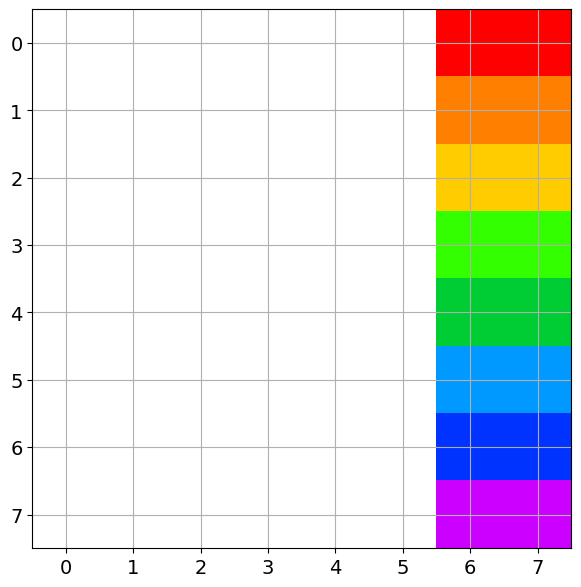

In [53]:
l = len(colors)
key = np.ones((l,l,3))
key.shape
for i in range(l):
    key[i,-int(l/4):,0] = colors[i][0]
    key[i,-int(l/4):,1] = colors[i][1]
    key[i,-int(l/4):,2] = colors[i][2]
plt.imshow(key)

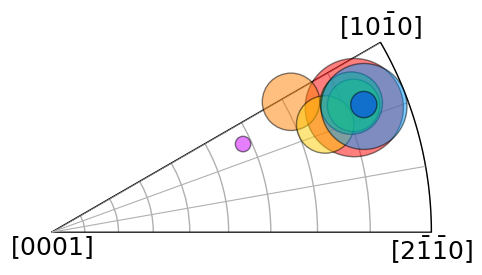

In [54]:
cluster_sizes_scaled = 5000 * cluster_sizes / cluster_sizes.max()
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="ipf", symmetry=pg_HCP))
ax.scatter(
    cluster_means.axis, c=colors, s=cluster_sizes_scaled, alpha=0.5, ec="k"
)


In [55]:
cluster_sizes

array([2138,  730,  732,  610,  861, 1638,  153,   53])

In [56]:
cluster_sizes.sum()

6915

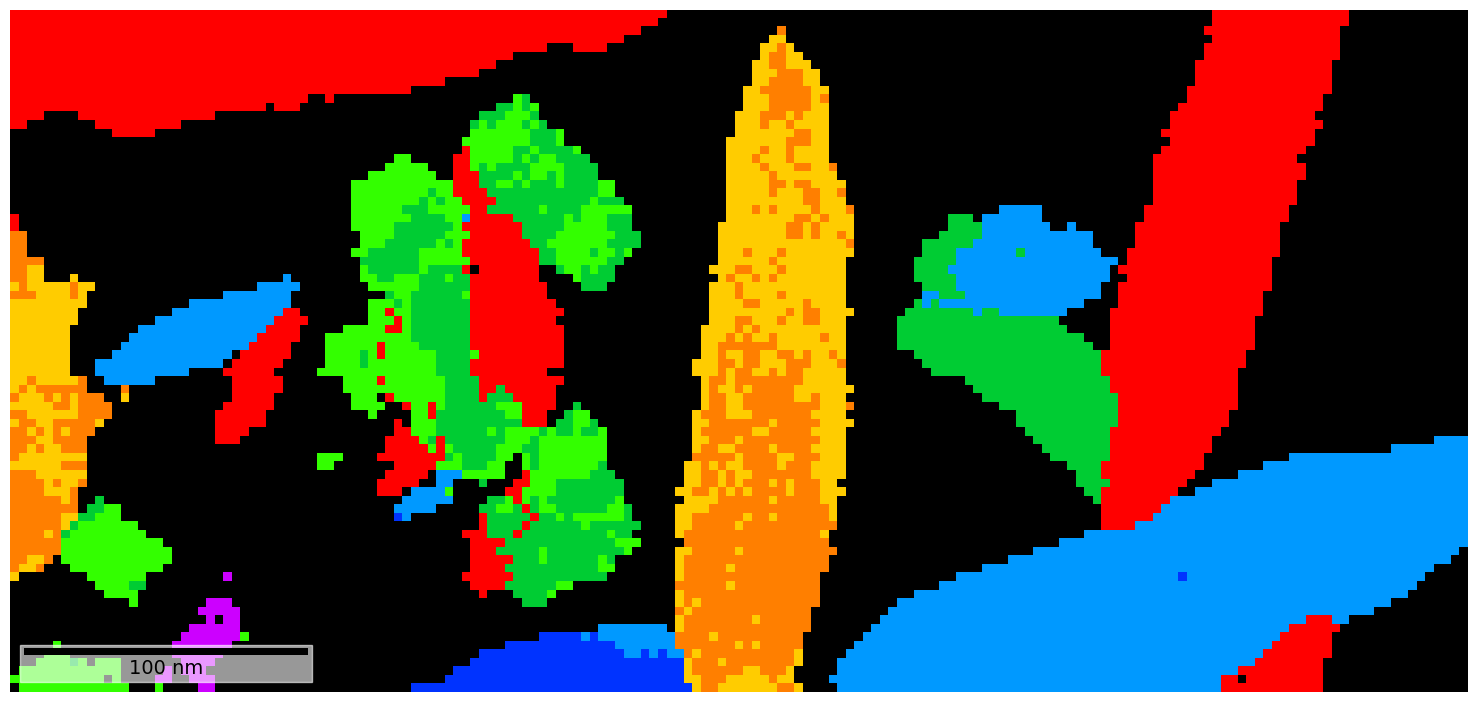

In [57]:
fig3, ax3 = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection="plot_map"))
ax3.plot_map(Timap["Alpha Titanium"], 
                   labels_rgb)
ax3.axis("off");
fig3.tight_layout()

In [58]:
#Swap x and y axes in orientation data for plotting nice stereograms
def Vectorswapper(v):
    v_data = v.data.copy()
    v_data[:,0] = v.data[:,1]
    v_data[:,1] = v.data[:,0]    
    vswap = Vector3d(v_data)
    return vswap

In [59]:
vh = Vector3d((0,0,1))
v_alpha = (ori_alpha * vh)
v1 = Vector3d((1, -1, 0))
v2 = Vector3d((1, 1, 0))
v3 = Vector3d((1, 0, 1))
v4 = Vector3d((1, 0, -1))
v5 = Vector3d((0, 1, 1))
v6 = Vector3d((0, 1, -1))
v1_fs = (ori_beta * v1)
v2_fs = (ori_beta * v2)
v3_fs = (ori_beta * v3)
v4_fs = (ori_beta * v4)
v5_fs = (ori_beta * v5)
v6_fs = (ori_beta * v6)

In [60]:
va1 = Vector3d((1,0,0))
va1_alpha = (ori_alpha * va1)
va2 = Vector3d((1,3**0.5,0))
va2_alpha = (ori_alpha * va2)
va3 = Vector3d((1,-3**0.5,0))
va3_alpha = (ori_alpha * va3)
vb1 = Vector3d((1, 1, 1))
vb2 = Vector3d((1, -1, 1))
vb1_fs = (ori_beta * vb1)
vb2_fs = (ori_beta * vb2)

In [61]:
v_alpha2 = Vectorswapper(v_alpha)
v_fs2 = Vectorswapper(v1_fs)
v2_fs2 = Vectorswapper(v2_fs)
va1_swap = Vectorswapper(va1_alpha)
va2_swap = Vectorswapper(va2_alpha)
va3_swap = Vectorswapper(va3_alpha)
vb1_swap = Vectorswapper(vb1_fs)
vb2_swap = Vectorswapper(vb2_fs)


In [62]:
#Find the background alpha rows (i.e. alpha that didn't fit in any cluster,
#probably misindexing or very small laths) and delete from colour and vector list
#for plotting stereogram cleanly
background_alpha_rows = np.where((labels_rgb == (0,0,0)).all(axis=1))
labels_rgb_pruned = np.delete(labels_rgb, background_alpha_rows, axis=0)
#v_alpha2_pruned = Vector3d(np.delete(v_alpha2.data, background_alpha_rows, axis=0))
v_alpha_pruned = Vector3d(np.delete(v_alpha2.data, background_alpha_rows, axis=0))
va1_alpha_pruned = Vector3d(np.delete(va1_swap.data, background_alpha_rows, axis=0))
va2_alpha_pruned = Vector3d(np.delete(va2_swap.data, background_alpha_rows, axis=0))
va3_alpha_pruned = Vector3d(np.delete(va3_swap.data, background_alpha_rows, axis=0))


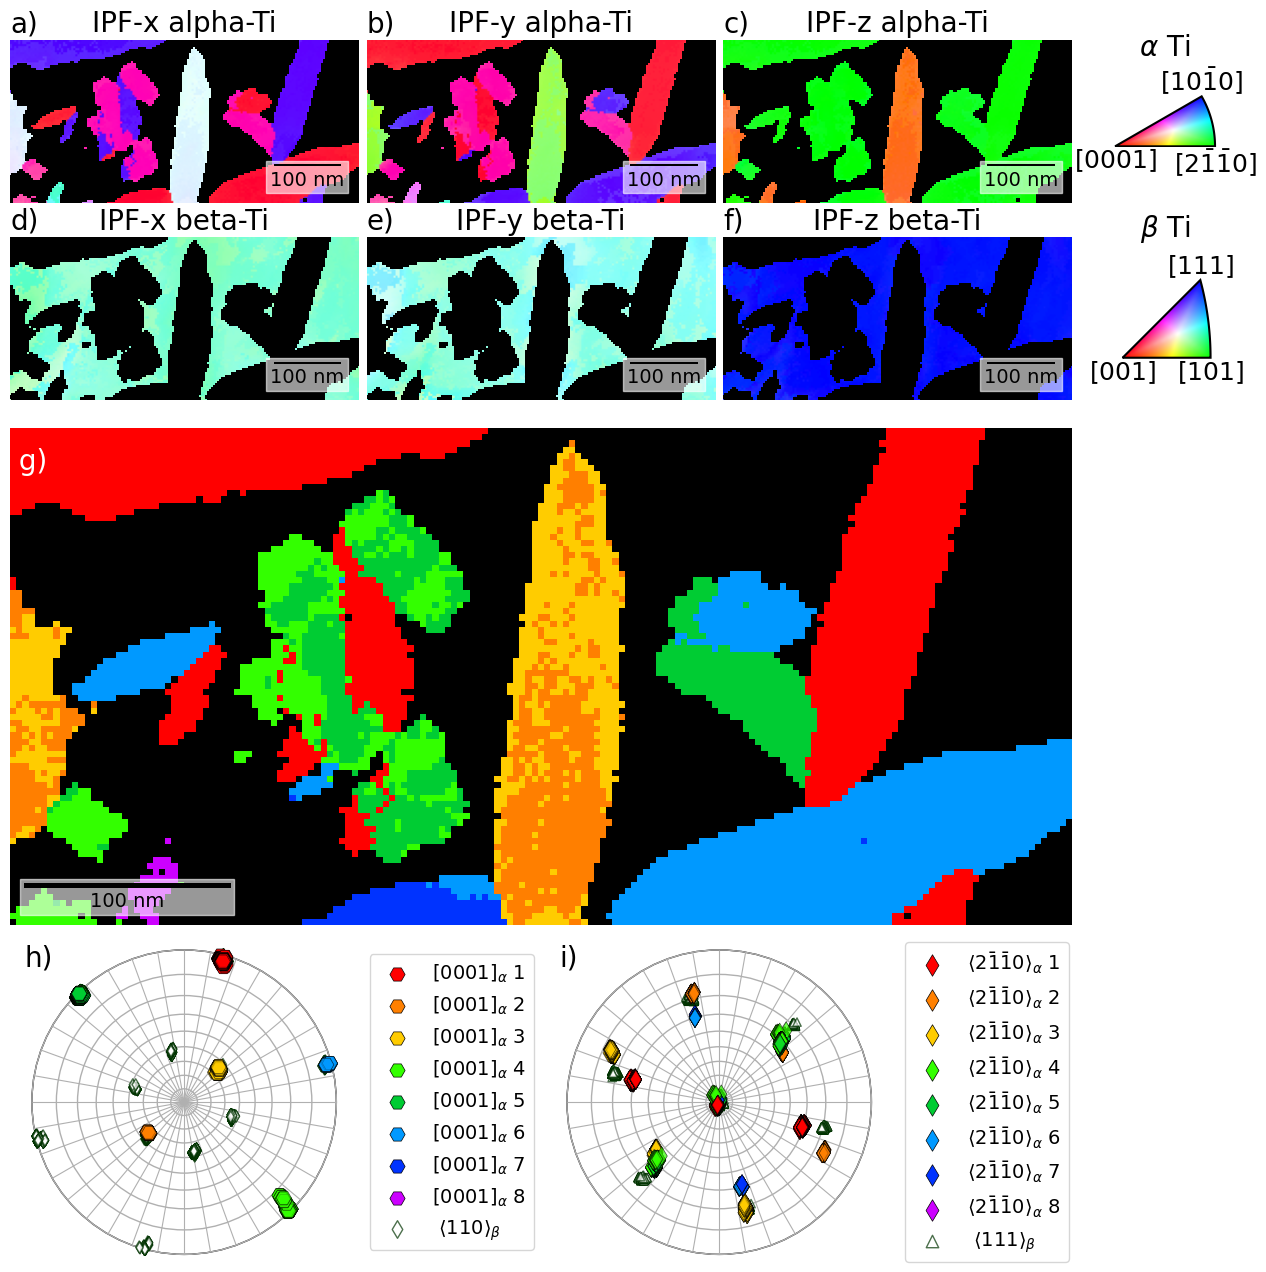

In [64]:
#Final figure with IPF maps, a pair of pole figures, and a distinct cluster map
plt.rcParams['savefig.facecolor']='w'
figname = 'Figure3'
fig = plt.figure(figsize=(16,16))
hr = [1,1,2.75,1.75]
gs = gridspec.GridSpec(4, 7, figure=fig, height_ratios=hr, 
                       wspace=0.05, hspace=0.05)

labels = ['x','y','z']
letter = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

for i in range(3):
    ax = plt.subplot(gs[0,i*2:i*2+2], projection="plot_map")
    ax.plot_map(Timap["Alpha Titanium"], rgb_alpha_xyz[i], 
                 scalebar_properties={"location": 4})
    ax.set_title(f'IPF-{labels[i]} alpha-Ti', size = 20)
    ax.set_axis_off()
    ax.set_title(letter[i], size=20, loc='left')
    
axb = plt.subplot(gs[0,6], projection='ipf', symmetry=pg_HCP)
axb.set_xlim(-.35,1.35)
axb.plot_ipf_color_key()
axb.set_title('', loc='left')
axb.set_title(r'$\alpha$ Ti', loc='center', y=1.6)

for i in range(3):
    axe = plt.subplot(gs[1,i*2:i*2+2], projection="plot_map")
    axe.plot_map(Timap["Beta Titanium"], 
             rgb_beta_xyz[i],
             scalebar_properties={"location": 4})
    axe.set_axis_off()
    axe.set_title(f'IPF-{labels[i]} beta-Ti', size = 20)
    axe.set_title(letter[i+3], size=20, loc='left')
    
axf = plt.subplot(gs[1,6], projection='ipf', symmetry=pg_BCC)
axf.set_xlim(-.2,0.6)
axf.plot_ipf_color_key()
axf.set_title('', loc='left')
axf.set_title(r'$\beta$ Ti', loc='center', y=1.4)

axi = plt.subplot(gs[2,0:6], projection='plot_map')
axi.plot_map(Timap["Alpha Titanium"], labels_rgb)
axi.axis("off")
axi.set_title(' '+letter[6], size=20, loc='left', y = 0.9, c='w')

axg = plt.subplot(gs[3,:2], projection='stereographic')
axg.scatter(
    v_fs2, 
    c='w', 
    label='beta <110>', 
    linewidths=1,
    ec=(0,0.2,0),
    alpha=0.7,
    marker='d'
)
axg.scatter(
    v2_fs2, 
    c='w', 
    linewidths=1, 
    edgecolors=(0,0.2,0), 
    alpha=0.7, 
    marker='d'
)
axg.scatter(
    v_alpha_pruned, 
    ec='k', 
    linewidths=0.5, 
    c=labels_rgb_pruned,
    label='alpha [0001]',
    alpha=0.7,
    s=120,
    marker='H'
)
axg.set_title(letter[7], size=20, loc='left', y = 0.9)

axh = plt.subplot(gs[3,2])
for i, col in enumerate(colors):
    axh.scatter([],[], color=col, ec='k', linewidths=0.5, 
                label=r'$[0001]_{\alpha}$ '+str(i+1), s=120, marker='H')
axh.scatter([],[], color='w', ec=(0,0.2,0), alpha=0.7, 
            marker = 'd', s=80, label=r' $\left<110\right>_{\beta}$')
axh.axis("off")
axh.legend(scatterpoints=1, loc='center')


axj = plt.subplot(gs[3,3:5], projection='stereographic')
axj.scatter(
    vb1_swap, 
    c='w', 
    linewidths=1,
    ec=(0,0.2,0),
    alpha=0.7,
    marker='^'
)
axj.scatter(
    vb2_swap, 
    c='w', 
    linewidths=1,
    ec=(0,0.2,0),
    alpha=0.7,
    marker='^'
)
axj.scatter(
    va1_alpha_pruned,
    ec='k', 
    linewidths=0.5,
    c=labels_rgb_pruned,
    alpha=0.7,
    s=90,
    marker='d'
)
axj.scatter(
    va2_alpha_pruned,
    ec='k', 
    linewidths=0.5,
    c=labels_rgb_pruned,
    alpha=0.7,
    s=90,
    marker='d'
)
axj.scatter(
    va3_alpha_pruned,
    ec='k', 
    linewidths=0.5,
    c=labels_rgb_pruned,
    alpha=0.7,
    s=90,
    marker='d'
)
axj.set_title(letter[8], size=20, loc='left', y = 0.9)

axk = plt.subplot(gs[3,5])
for i, col in enumerate(colors):
    axk.scatter([],[], color=col, ec='k', linewidths=0.5, 
                label=r'$\left<2\bar1\bar10\right>_{\alpha}$ '+str(i+1), s=120, marker='d')
axk.scatter([],[], color='w', ec=(0,0.2,0), alpha=0.7, 
            marker = '^', s=80, label=r' $\left<111\right>_{\beta}$')
axk.axis("off")
axk.legend(scatterpoints=1, loc='center')


fig.savefig(filepath+'Figure3.png', dpi=300, bbox_inches='tight')